# Preprocessing

In [1]:
import pickle
import json
import os
from preprocessing import clean_gt, clean_raw, label_entity

In [ ]:
split = pickle.load(open('data/train_test_eval_filenames_new.pkl', 'rb'))
split

In [39]:
#train = 94, test = 30, eval = 10

In [3]:
# import random
# new_split = {"train":[], "test": [], "eval": []}
# for key in split:
#     for page in split[key]:
#         mag = page.split("_")[0].split("-")[0]
#         year = page.split("_")[1]
        
#         if mag == "dkm" and (year == "1941" or year == "2010"):
#             new_split["train"].append(page)
#         if (year == "1990"):
#             new_split["test"].append(page)
#         if mag =="sbz" and (year == "1895" or year == "1940" or year == "1965" or year == "2010"):
#             new_split["train"].append(page)

# eval_set = random.sample(new_split["train"], int(len(new_split["train"])/10)) #set 10% of train aside for eval
# for page in eval_set:
#     new_split["train"].remove(page)
# new_split["eval"] = eval_set

# with open('train_test_eval_filenames_new.pkl', 'wb') as out:
#     pickle.dump(new_split, out)

In [4]:
"""
data = {
    "train": [],
    "test": [],
    "eval": []
}
gt_data = []
for mag in ["dkm", "sbz"]:
    for year in os.listdir(f'data/raw/link/{mag}'):
        with open(os.path.join("data/raw/link", mag, year)) as f:
            input_linked = json.load(f)
        with open(os.path.join("data/ground-truth", mag, year)) as f:
            gt = json.load(f)
        gt = clean_gt(gt)
        gt_data += gt
        input_linked = clean_raw(input_linked)

        #due to non-determinism in the flair NER:
        all_refs_gt = [g["page"]+g["coord"] for g in gt] 
        all_refs_linked = [ent["page"]+ent["coord"] for l in input_linked for ent in l]
        all_valid_refs = set(all_refs_gt).intersection(set(all_refs_linked))

        for ent_variations in input_linked:
            for key in split:
                ent_instances = []
                for ent in ent_variations:
                    if ent["page"] in split[key]:
                        if (ent["page"]+ent["coord"]) in all_valid_refs:
                            ent_instances.append({"ent": ent, "label": label_entity(ent, gt)})
                if ent_instances:
                    data[key].append(ent_instances)
"""

In [5]:
"""
with open("data/processed.pkl", "wb") as f:
    pickle.dump(data, f)
"""

# Candidate Generation

In [1]:
import pickle
from tqdm.notebook import  tqdm
from candidate_generation import create_metagrid_candidates, get_candidates_fuseki

In [ ]:
# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

for split in ["train", "eval", "test"]:
    ent_cand_label = []
    i = 0
    for entity_list in tqdm(data[split], smoothing=0.01):
        i += 1
        # Create candidates only for the first entry in the list as all the entity information is always the same
        # The only thing that changes are pages and page_coordinates
        candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
        # Generate the list of page_coordinates and the corresponding labels!
        coord_list = []
        label_list = []
        for ent_dict in entity_list:
            ent = ent_dict["ent"]
            coord_list.append({
                "page": ent.pop("page", ""), 
                "coords": ent.pop("coord", "")
            })
            label_list.append(ent_dict["label"])
        ent_cand_label.append({"entity": ent, "candidates": candidates, "occurences": coord_list, "labels": label_list})
        if i % 100 == 0:
            with open(f"candidates-gnd-{split}.pkl", "wb") as f:
                pickle.dump(ent_cand_label, f)
                    
    with open(f"candidates-gnd-{split}.pkl", "wb") as f:
       pickle.dump(ent_cand_label, f)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

# Feature Generation

### To get the relevant fastttext model uncomment and run the following cell

In [38]:
# from gensim.models.fasttext import FastText, load_facebook_vectors
# model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")
# model.save("./fasttext")

In [3]:
import pickle
from tqdm.notebook import  tqdm
from feature_generation import candidates_to_features, process_fuseki_candidates

In [55]:
#AF:
from tqdm import tqdm
# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

problematic_entities = []
for split in ["train", "eval", "test"]:
    ent_cand_label = []
    i = 0
    for entity_list in tqdm(data[split], smoothing=0.01):
        i += 1
        # Create candidates only for the first entry in the list as all the entity information is always the same
        # The only thing that changes are pages and page_coordinates
        
        # fuseki:
        unique_candidate_dict = get_candidates_fuseki(entity_list[0]["ent"])
        candidates = process_fuseki_candidates(unique_candidate_dict)
        #print(process_fuseki_candidates(unique_candidate_dict))
        #list_of_tuples.append((ent, processed_fuseki_cands, ent_dict["label"]))
        
        #metagrid
        ## candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
        # Generate the list of page_coordinates and the corresponding labels!
        coord_list = []
        gt_label = []
        for ent_dict in entity_list:
            ent = ent_dict["ent"]
            coord_list.append({
                "page": ent.pop("page", ""), 
                "coords": ent.pop("coord", "")
            })
            gt_label.append(ent_dict["label"])

        #if len(gt_label)!=1:
        #    problematic_entities.append({"ent_list": entity_list, "gt_labels": gt_label, "mag": coord_list})
        #gt_label = gt_label.pop()
        
        ent_cand_label.append({"entity": ent, "candidates": candidates, "occurences": coord_list, "gt_label": gt_label})
        if i % 100 == 0:
            with open(f"data/candidates/candidates-gnd-{split}-{i}.pkl", "wb") as f:
                pickle.dump(ent_cand_label, f)
                    
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "wb") as f:
       pickle.dump(ent_cand_label, f)
print(problematic_entities)


  0%|          | 0/574 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

# Feature Generation

Uncomment and run this to load and save the fasttext model

In [1]:
# from gensim.models.fasttext import FastText, load_facebook_vectors
# model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")
# model.save("./fasttext")

In [2]:
import pickle
from tqdm import  tqdm
from feature_generation import create_features, get_gnd

KeyboardInterrupt: 

In [ ]:
for split in ["train", "eval", "test"]:
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "rb") as f:
        ent_cand_label = pickle.load(f)

    list_of_good_entities = []
    list_of_problematic_entities = []
    for ent_dict in tqdm(ent_cand_label):
        if len(set(ent_dict["labels"])) > 1:
            for label in set(ent_dict["labels"]):
                ent_dict["label"] = label
                features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["label"])
                ent_dict.update(features)
                list_of_problematic_entities.append(ent_dict.copy())
        else:
            ent_dict["label"] = set(ent_dict["labels"]).pop()
            features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["label"])
            ent_dict.update(features)
            list_of_good_entities.append(ent_dict)
            
    with open(f"data/features/{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)
    
    with open(f"data/features/{split}_problematic.pkl", "wb") as f:
        pickle.dump(list_of_problematic_entities, file=f)

## Unsupervised Feature Generation

In [1]:
import numpy as np
import logging
import pickle
from tqdm.notebook import  tqdm
import importlib
import unsupervised.raw_text_driver
importlib.reload(unsupervised.raw_text_driver)
import unsupervised.portal_dnb_driver
importlib.reload(unsupervised.portal_dnb_driver)
import unsupervised.data_loader
with open(f"data/features/train.pkl", "rb") as f:
    list_of_good_entities = pickle.load(f)

importlib.reload(unsupervised.data_loader)


data_loader = unsupervised.data_loader.DataLoader(raw_data_path='/home/aheser/ETH-CS4NLP-22-Project-Linking-GND/data/input/raw')

Available models: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
Available models: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
logging.basicConfig(level=logging.WARNING)
avg_distance_counter = 0
avg_distance = np.array((1,))
for split in ["train", "eval", "test"]:
# for split in ["eval"]:
    print('processing', split)
    with open(f"data/features/{split}.pkl", "rb") as f:
        list_of_good_entities = pickle.load(f)
    
    for current_entity in tqdm(list_of_good_entities):
        distances = data_loader.get_context_distances(current_entity, similarity_measure='cosine_similarity', window_size=10)
        for feature_counter in range(len(current_entity['features'])):
            current_entity['features'][feature_counter].extend(distances[feature_counter])
#             print('avg distance', avg_distance, 'distance vec', distances[feature_counter])
            avg_distance = avg_distance + np.array(distances[feature_counter])
            avg_distance_counter = avg_distance_counter + 1
        
    
    with open(f"data/features/unsupervised_{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)

avg_distance = avg_distance / avg_distance_counter
# problematic ones (we don't have any vectors, use mean)
for split in ["train", "eval", "test"]:
    print('processing', split)
    with open(f"data/features/{split}_problematic.pkl", "rb") as f:
        list_of_good_entities = pickle.load(f)
    
    for current_entity in tqdm(list_of_good_entities):
        for feature_counter in range(len(current_entity['features'])):
            current_entity['features'][feature_counter].extend(avg_distance)
    
    with open(f"data/features/unsupervised_{split}_problematic.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)

processing train


  0%|          | 0/561 [00:00<?, ?it/s]

avg distance [1] distance vec [1.2652079251697526]
avg distance [2.26520793] distance vec [1.2361578287510746]
avg distance [3.50136575] distance vec [1.2985532133851916]
avg distance [4.79991897] distance vec [1.1738141821667774]
avg distance [5.97373315] distance vec [1.1991709568349407]
avg distance [7.17290411] distance vec [0.8620652391141873]
avg distance [8.03496935] distance vec [0.8596677910488022]
avg distance [8.89463714] distance vec [0.865664690035279]
avg distance [9.76030183] distance vec [0.8588002955745326]
avg distance [10.61910212] distance vec [0.8607831975933522]
avg distance [11.47988532] distance vec [0.8634896703379562]
avg distance [12.34337499] distance vec [0.862148423607372]
avg distance [13.20552341] distance vec [0.8634288115486032]
avg distance [14.06895223] distance vec [0.8631217112137656]
avg distance [14.93207394] distance vec [0.8633473298183463]
avg distance [15.79542127] distance vec [0.8613799045661199]
avg distance [16.65680117] distance vec [0.8

avg distance [547.59964217] distance vec [0.3739985826126684]
avg distance [547.97364075] distance vec [0.37775758005581594]
avg distance [548.35139833] distance vec [0.37720466080587967]
avg distance [548.72860299] distance vec [0.38025440216920814]
avg distance [549.1088574] distance vec [0.377786353097358]
avg distance [549.48664375] distance vec [0.37996421061876806]
avg distance [549.86660796] distance vec [0.38031480808993656]
avg distance [550.24692277] distance vec [0.3805477814337439]
avg distance [550.62747055] distance vec [0.37918923909674596]
avg distance [551.00665979] distance vec [0.3787576366827332]
avg distance [551.38541742] distance vec [0.37974894837228823]
avg distance [551.76516637] distance vec [0.38165865971165025]
avg distance [552.14682503] distance vec [1.1852929206691296]
avg distance [553.33211795] distance vec [1.2354597576960737]
avg distance [554.56757771] distance vec [0.45022167946304037]
avg distance [555.01779939] distance vec [0.4524001164619281]
a

avg distance [663.96846412] distance vec [0.5412078315055897]
avg distance [664.50967195] distance vec [1.1825711690879703]
avg distance [665.69224312] distance vec [1.2652681927035243]
avg distance [666.95751131] distance vec [1.2206587721696776]
avg distance [668.17817008] distance vec [0.6210174791445371]
avg distance [668.79918756] distance vec [0.6258644638047083]
avg distance [669.42505203] distance vec [1.200738280907848]
avg distance [670.62579031] distance vec [0.7108744131510202]
avg distance [671.33666472] distance vec [0.7191534779599461]
avg distance [672.0558182] distance vec [1.21249918986776]
avg distance [673.26831739] distance vec [1.0923605155972707]
avg distance [674.3606779] distance vec [0.7127605636501378]
avg distance [675.07343847] distance vec [1.2016103368757638]
avg distance [676.2750488] distance vec [1.2470657928079572]
avg distance [677.5221146] distance vec [0.9626848108136006]
avg distance [678.48479941] distance vec [0.9635060496220406]
avg distance [6

avg distance [771.89724853] distance vec [0.6503387656844921]
avg distance [772.54758729] distance vec [0.6483974883353181]
avg distance [773.19598478] distance vec [0.6469512936972701]
avg distance [773.84293608] distance vec [0.6478740509872434]
avg distance [774.49081013] distance vec [0.6490924079153065]
avg distance [775.13990254] distance vec [1.1929510450599445]
avg distance [776.33285358] distance vec [0.7150146628695317]
avg distance [777.04786824] distance vec [1.2322710070922769]
avg distance [778.28013925] distance vec [0.5744875025936305]
avg distance [778.85462675] distance vec [0.5748621301501475]
avg distance [779.42948888] distance vec [1.1631212041435761]
avg distance [780.59261009] distance vec [1.1787631214305696]
avg distance [781.77137321] distance vec [0.6987038917383244]
avg distance [782.4700771] distance vec [1.1981414538536623]
avg distance [783.66821855] distance vec [1.2486802746488825]
avg distance [784.91689883] distance vec [1.2260472349899423]
avg dista

avg distance [897.60472753] distance vec [0.3638565665293033]
avg distance [897.9685841] distance vec [0.3606273119623674]
avg distance [898.32921141] distance vec [0.3588445503926131]
avg distance [898.68805596] distance vec [0.36133477607582654]
avg distance [899.04939074] distance vec [1.2366662155076975]
avg distance [900.28605695] distance vec [0.5135549380212789]
avg distance [900.79961189] distance vec [0.5125555104892715]
avg distance [901.3121674] distance vec [0.5147702833413184]
avg distance [901.82693768] distance vec [1.0970279100083487]
avg distance [902.92396559] distance vec [0.37875602292299837]
avg distance [903.30272162] distance vec [1.2099177691817387]
avg distance [904.51263938] distance vec [0.6914908652493368]
avg distance [905.20413025] distance vec [0.6904495276472694]
avg distance [905.89457978] distance vec [1.213606700507613]
avg distance [907.10818648] distance vec [1.241490746130452]
avg distance [908.34967722] distance vec [0.7151632295128396]
avg distan

/home/aheser/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:630: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


avg distance [989.01863437] distance vec [0.2233402798536832]
avg distance [989.24197465] distance vec [0.225432307345252]
avg distance [989.46740695] distance vec [0.22601361114340868]
avg distance [989.69342057] distance vec [0.2250890091608394]
avg distance [989.91850958] distance vec [0.22506711156259662]
avg distance [990.14357669] distance vec [0.22309113477701292]
avg distance [990.36666782] distance vec [0.22492279779076962]
avg distance [990.59159062] distance vec [0.22294216251025945]
avg distance [990.81453278] distance vec [0.22485962233407508]
avg distance [991.0393924] distance vec [0.22567009981858122]
avg distance [991.2650625] distance vec [0.2225808778505043]
avg distance [991.48764338] distance vec [0.22692003894889312]
avg distance [991.71456342] distance vec [0.22675075090318142]
avg distance [991.94131417] distance vec [0.2211502903522632]
avg distance [992.16246446] distance vec [0.2256956123082392]
avg distance [992.38816007] distance vec [0.22502198766265735]
a

avg distance [1090.61979435] distance vec [0.4515096507287477]
avg distance [1091.071304] distance vec [0.4464969710377319]
avg distance [1091.51780097] distance vec [0.4560466097192587]
avg distance [1091.97384758] distance vec [0.451073724808814]
avg distance [1092.42492131] distance vec [0.4470051366327461]
avg distance [1092.87192644] distance vec [0.44791460695006924]
avg distance [1093.31984105] distance vec [0.45166272104383465]
avg distance [1093.77150377] distance vec [0.44883291358445787]
avg distance [1094.22033668] distance vec [0.4411948551726287]
avg distance [1094.66153154] distance vec [0.4527081855910091]
avg distance [1095.11423972] distance vec [0.4519041519511743]
avg distance [1095.56614388] distance vec [0.4519453246562949]
avg distance [1096.0180892] distance vec [0.4417743696886992]
avg distance [1096.45986357] distance vec [0.4520650681323425]
avg distance [1096.91192864] distance vec [0.44907568463689784]
avg distance [1097.36100432] distance vec [0.4539497346

avg distance [1439.67231447] distance vec [0.7148132697102904]
avg distance [1440.38712774] distance vec [0.7186608199132838]
avg distance [1441.10578856] distance vec [0.7204122752553739]
avg distance [1441.82620084] distance vec [0.7217246930869232]
avg distance [1442.54792553] distance vec [0.7239489870342751]
avg distance [1443.27187452] distance vec [1.275709977507106]
avg distance [1444.5475845] distance vec [1.1720939735297247]
avg distance [1445.71967847] distance vec [1.2559952490537554]
avg distance [1446.97567372] distance vec [1.23289918366901]
avg distance [1448.2085729] distance vec [1.23289918366901]
avg distance [1449.44147209] distance vec [0]
avg distance [1449.44147209] distance vec [0.535945501073386]
avg distance [1449.97741759] distance vec [0.53609270124592]
avg distance [1450.51351029] distance vec [1.2078614304515098]
avg distance [1451.72137172] distance vec [0.8312814640386287]
avg distance [1452.55265318] distance vec [0.8290593348625714]
avg distance [1453.

avg distance [1918.94387664] distance vec [0.7672659540124316]
avg distance [1919.7111426] distance vec [0.7683255930915847]
avg distance [1920.47946819] distance vec [0.7746451359938427]
avg distance [1921.25411333] distance vec [0.7710926547481807]
avg distance [1922.02520598] distance vec [0.7679071552706911]
avg distance [1922.79311314] distance vec [0.7716037224498861]
avg distance [1923.56471686] distance vec [0.769789612170622]
avg distance [1924.33450647] distance vec [0.7698131039715117]
avg distance [1925.10431958] distance vec [0.7678293000375215]
avg distance [1925.87214888] distance vec [0.768273495868358]
avg distance [1926.64042237] distance vec [0.7713413222246494]
avg distance [1927.41176369] distance vec [0.7692063602486123]
avg distance [1928.18097005] distance vec [0.7702421487315261]
avg distance [1928.9512122] distance vec [0.768139668924438]
avg distance [1929.71935187] distance vec [0.7675943796748826]
avg distance [1930.48694625] distance vec [0.769761762048069

avg distance [2175.88246864] distance vec [0.33339571010295743]
avg distance [2176.21586435] distance vec [0.33386252655237647]
avg distance [2176.54972688] distance vec [0.332667792872567]
avg distance [2176.88239467] distance vec [0.3325706983176139]
avg distance [2177.21496537] distance vec [0.3287477637393331]
avg distance [2177.54371313] distance vec [0.33420958317164573]
avg distance [2177.87792272] distance vec [0.3333076066127475]
avg distance [2178.21123032] distance vec [0.33175741730942565]
avg distance [2178.54298774] distance vec [0.33072153918504743]
avg distance [2178.87370928] distance vec [0.3298870099371961]
avg distance [2179.20359629] distance vec [0.33234350473825125]
avg distance [2179.5359398] distance vec [0.33250841998974845]
avg distance [2179.86844822] distance vec [0.33251105874265896]
avg distance [2180.20095927] distance vec [0.3321936598467853]
avg distance [2180.53315293] distance vec [0.3328133638995908]
avg distance [2180.8659663] distance vec [0.33161

avg distance [2234.86125962] distance vec [0.8037685596860991]
avg distance [2235.66502818] distance vec [0.8024843165951829]
avg distance [2236.4675125] distance vec [0.8004012652441095]
avg distance [2237.26791376] distance vec [0.8035312480577376]
avg distance [2238.07144501] distance vec [0.8013254708143644]
avg distance [2238.87277048] distance vec [0.8034863390173363]
avg distance [2239.67625682] distance vec [0.8042861969301955]
avg distance [2240.48054302] distance vec [0.8002976068662992]
avg distance [2241.28084062] distance vec [0.7986950265309791]
avg distance [2242.07953565] distance vec [0.7985702371813713]
avg distance [2242.87810589] distance vec [0.8024801103644273]
avg distance [2243.680586] distance vec [0.8027902949865874]
avg distance [2244.48337629] distance vec [0.8025366223169874]
avg distance [2245.28591291] distance vec [0.8027350223388587]
avg distance [2246.08864794] distance vec [0.8030688915913884]
avg distance [2246.89171683] distance vec [0.8030958819795

avg distance [2358.42314405] distance vec [0.2839579924048131]
avg distance [2358.70710204] distance vec [1.2178435207827074]
avg distance [2359.92494556] distance vec [0.3210900403006097]
avg distance [2360.2460356] distance vec [1.2326389217536606]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [0]
avg distance [2361.47867452] distance vec [1.1398157841904872]
avg distance [2362.61849031] distance vec [0.33971516195903095]
avg distance [2362.95820547] distance vec [1.137402248770293]
avg distance [2364.09560772] distance vec [1.1264474790450356]
avg distance [2365.2220552] distance vec [1.1964666356340574]
avg distance [2366.41852183] distance vec [1.2252561615868034]
avg distance [2367.64377799] distance vec [1.2352139402482851]
avg distance [2368.87899193] dist

avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] distance vec [0]
avg distance [2717.66048265] dista

avg distance [2754.11117197] distance vec [0.21016423923411964]
avg distance [2754.32133621] distance vec [0.2099799328544414]
avg distance [2754.53131615] distance vec [0.2093975704674661]
avg distance [2754.74071372] distance vec [0.20741613067410902]
avg distance [2754.94812985] distance vec [0.21114053792894827]
avg distance [2755.15927039] distance vec [0.21075350768734458]
avg distance [2755.37002389] distance vec [0.2113829530009218]
avg distance [2755.58140685] distance vec [0.20844017434564244]
avg distance [2755.78984702] distance vec [0.2068776661947952]
avg distance [2755.99672469] distance vec [0.20720978603622275]
avg distance [2756.20393447] distance vec [0.20986985617634368]
avg distance [2756.41380433] distance vec [0.20992321557807248]
avg distance [2756.62372755] distance vec [0.20992393007307286]
avg distance [2756.83365148] distance vec [0.20918356879635414]
avg distance [2757.04283504] distance vec [0.2103751312864779]
avg distance [2757.25321018] distance vec [0.

avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] distance vec [0]
avg distance [2835.76536161] dista

avg distance [2865.1225787] distance vec [0.7257491214030477]
avg distance [2865.84832782] distance vec [0.7258304597650718]
avg distance [2866.57415828] distance vec [0.7269726808828865]
avg distance [2867.30113096] distance vec [0.7250333186089437]
avg distance [2868.02616428] distance vec [0.7282531605993136]
avg distance [2868.75441744] distance vec [0.7290593411107118]
avg distance [2869.48347678] distance vec [0.729340557078212]
avg distance [2870.21281734] distance vec [0.7279466028671523]
avg distance [2870.94076394] distance vec [0.7293770720451369]
avg distance [2871.67014101] distance vec [0.7293244289520104]
avg distance [2872.39946544] distance vec [0.7219992366516732]
avg distance [2873.12146468] distance vec [0.7285793458892522]
avg distance [2873.85004402] distance vec [0.7287556897534537]
avg distance [2874.57879971] distance vec [0.7294691980934349]
avg distance [2875.30826891] distance vec [0.7261095664958827]
avg distance [2876.03437848] distance vec [0.729074380375

avg distance [2960.4963944] distance vec [0.5555045178227898]
avg distance [2961.05189891] distance vec [0.55318689843317]
avg distance [2961.60508581] distance vec [0.5574244745112453]
avg distance [2962.16251029] distance vec [0.5563735582612312]
avg distance [2962.71888385] distance vec [0.5576389456645241]
avg distance [2963.27652279] distance vec [0.5568579270176724]
avg distance [2963.83338072] distance vec [0.5579990588878295]
avg distance [2964.39137978] distance vec [0.5557715185257905]
avg distance [2964.9471513] distance vec [0.5497198142661222]
avg distance [2965.49687111] distance vec [0.5541974932671392]
avg distance [2966.0510686] distance vec [0.5522478121643943]
avg distance [2966.60331642] distance vec [0.5602220076270854]
avg distance [2967.16353842] distance vec [0.5566430778283562]
avg distance [2967.7201815] distance vec [0.5554861004274139]
avg distance [2968.2756676] distance vec [0.557234375073232]
avg distance [2968.83290198] distance vec [0.5569376198883911]


avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [0]
avg distance [3048.24826388] distance vec [1.2685257010254265]
avg distance [3049.51678958] distance vec [0.6816889895292967]
avg distance [3050.19847857] distance vec [1.2748179316964283]
avg distance [3051.4732965] distance vec [1.3078449927597273]
avg distance [3052.78114149] distance vec [0.8321669630502454]
avg distance [3053.61330845] distance vec [1.2535061626938697]
avg distance [3054.86681462] distance vec [1.2204374300947916]
avg distance [3056.08725205] distance vec [1.250020988

avg distance [3146.8010879] distance vec [0.6528666773923123]
avg distance [3147.45395458] distance vec [0.6524765666190088]
avg distance [3148.10643115] distance vec [0.6558490914447045]
avg distance [3148.76228024] distance vec [0.6572791598916501]
avg distance [3149.4195594] distance vec [0.6526697593098176]
avg distance [3150.07222916] distance vec [1.215920008931337]
avg distance [3151.28814917] distance vec [1.2022015428078578]
avg distance [3152.49035071] distance vec [1.2844552008769543]
avg distance [3153.77480591] distance vec [0.8040971732382631]
avg distance [3154.57890308] distance vec [1.2640839764377811]
avg distance [3155.84298706] distance vec [0.8271889960915179]
avg distance [3156.67017606] distance vec [1.283825333482067]
avg distance [3157.95400139] distance vec [1.2603453202920007]
avg distance [3159.21434671] distance vec [1.00427663037445]
avg distance [3160.21862334] distance vec [1.1389380669832125]
avg distance [3161.35756141] distance vec [1.2208783391448743

avg distance [3193.02551076] distance vec [0.7025704449687331]
avg distance [3193.72808121] distance vec [0.7012343669045833]
avg distance [3194.42931557] distance vec [0.7028063299505487]
avg distance [3195.1321219] distance vec [0.7051916796627364]
avg distance [3195.83731358] distance vec [0.7048828666704305]
avg distance [3196.54219645] distance vec [0.702228388713113]
avg distance [3197.24442484] distance vec [0.7028965324064709]
avg distance [3197.94732137] distance vec [0.7016952611000233]
avg distance [3198.64901663] distance vec [0.7007396933845673]
avg distance [3199.34975633] distance vec [0.7058615619851778]
avg distance [3200.05561789] distance vec [0.7016740400773127]
avg distance [3200.75729193] distance vec [0.7033317647685612]
avg distance [3201.46062369] distance vec [0.7034279010052324]
avg distance [3202.16405159] distance vec [0.7046040255190651]
avg distance [3202.86865562] distance vec [0.7032246835183181]
avg distance [3203.5718803] distance vec [0.7036885613373

avg distance [3331.96603272] distance vec [0.7929272346858905]
avg distance [3332.75895995] distance vec [0.7873526101471173]
avg distance [3333.54631256] distance vec [0.7908355009558973]
avg distance [3334.33714806] distance vec [0.7910603486195402]
avg distance [3335.12820841] distance vec [0.7925561055218217]
avg distance [3335.92076452] distance vec [0.7914277597085546]
avg distance [3336.71219228] distance vec [0.7914749701774084]
avg distance [3337.50366725] distance vec [0.7905690177808921]
avg distance [3338.29423627] distance vec [0.7920104141187185]
avg distance [3339.08624668] distance vec [0.7891147330457776]
avg distance [3339.87536141] distance vec [0.7917777508831463]
avg distance [3340.66713916] distance vec [0.79072583078702]
avg distance [3341.45786499] distance vec [0.7925500964829163]
avg distance [3342.25041509] distance vec [0.7920358583692706]
avg distance [3343.04245095] distance vec [0.79175255995993]
avg distance [3343.83420351] distance vec [0.79081210319313

avg distance [3456.68116007] distance vec [1.0037602504407797]
avg distance [3457.68492032] distance vec [1.00403918285002]
avg distance [3458.68895951] distance vec [1.0057730349238527]
avg distance [3459.69473254] distance vec [1.006383219356508]
avg distance [3460.70111576] distance vec [1.0039568002492019]
avg distance [3461.70507256] distance vec [1.00589755660206]
avg distance [3462.71097012] distance vec [1.211698347380134]
avg distance [3463.92266847] distance vec [0.5959612339904203]
avg distance [3464.5186297] distance vec [1.0842481140842088]
avg distance [3465.60287781] distance vec [1.2206452721124048]
avg distance [3466.82352309] distance vec [0.7006102784374548]
avg distance [3467.52413336] distance vec [1.2403913555238404]
avg distance [3468.76452472] distance vec [0]
avg distance [3468.76452472] distance vec [0]
avg distance [3468.76452472] distance vec [0]
avg distance [3468.76452472] distance vec [0]
avg distance [3468.76452472] distance vec [0]
avg distance [3468.76

avg distance [3592.48451132] distance vec [0.7217971316840529]
avg distance [3593.20630845] distance vec [0.7208139216300631]
avg distance [3593.92712237] distance vec [0.7213433678806813]
avg distance [3594.64846574] distance vec [0.7217594724245291]
avg distance [3595.37022521] distance vec [0.7190895255354314]
avg distance [3596.08931474] distance vec [0.7211288745315012]
avg distance [3596.81044361] distance vec [0.7205183882078039]
avg distance [3597.530962] distance vec [0.7204470569246705]
avg distance [3598.25140906] distance vec [0.720625673716166]
avg distance [3598.97203473] distance vec [0.7189791592026401]
avg distance [3599.69101389] distance vec [0.7209251833793239]
avg distance [3600.41193908] distance vec [0.7189604735342652]
avg distance [3601.13089955] distance vec [0.7202008161651634]
avg distance [3601.85110037] distance vec [0.7215021453966398]
avg distance [3602.57260251] distance vec [0.7209320567201445]
avg distance [3603.29353457] distance vec [1.1402867205409

avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0]
avg distance [3663.59730129] distance vec [0.5851548291519977]
avg distance [3664.18245612] distance vec [0.5965305242585567]
avg distance [3664.77898664] distance vec [1.2372580232223314]
avg distance [3666.01624467] distance vec [0]
avg distance [3666.01624467] distance vec [0.4840928748761453]
avg distance [3666.50033754] distance vec [1.2211197548545663]
avg distance [3667.7214573] distance vec [0]
avg distance [3667.7214573] distance vec [0]
avg distance [3667.7214573] distance vec [0.35784939257135717]
avg distance [3668.07930669] distance vec [0.35979767526526374]
avg distance [3668.43910436] distance vec [0.3557428043211094]
avg distance [3668.79484717] distance vec [0.35510025633810016]
avg distance [3669.

avg distance [3968.89809865] distance vec [0.6888101398884438]
avg distance [3969.58690879] distance vec [0.6892493173422443]
avg distance [3970.2761581] distance vec [0.6894134482555516]
avg distance [3970.96557155] distance vec [0.6896563230819328]
avg distance [3971.65522787] distance vec [0.6854511027738897]
avg distance [3972.34067898] distance vec [0.6910788746949117]
avg distance [3973.03175785] distance vec [0.6876283397275706]
avg distance [3973.71938619] distance vec [0.6868522356962548]
avg distance [3974.40623843] distance vec [0.6885598825619239]
avg distance [3975.09479831] distance vec [0.6889356148875572]
avg distance [3975.78373392] distance vec [0.688746675803463]
avg distance [3976.4724806] distance vec [0.6913272193956892]
avg distance [3977.16380782] distance vec [0.6885819226598187]
avg distance [3977.85238974] distance vec [0.6878840920850298]
avg distance [3978.54027383] distance vec [0.6909501574293408]
avg distance [3979.23122399] distance vec [0.6867334008057

avg distance [4615.13965476] distance vec [0.8474487128600319]
avg distance [4615.98710347] distance vec [0.8439379635848127]
avg distance [4616.83104143] distance vec [0.8484155354557226]
avg distance [4617.67945697] distance vec [0.8460037099018727]
avg distance [4618.52546068] distance vec [0.847238917568799]
avg distance [4619.37269959] distance vec [0.8460495106015964]
avg distance [4620.21874911] distance vec [0.8477386805023653]
avg distance [4621.06648779] distance vec [0.847711943890583]
avg distance [4621.91419973] distance vec [0.8433844611665487]
avg distance [4622.75758419] distance vec [0.8471182917087252]
avg distance [4623.60470248] distance vec [0.8463715731955639]
avg distance [4624.45107406] distance vec [0.845291500359222]
avg distance [4625.29636556] distance vec [0.8440846787193289]
avg distance [4626.14045023] distance vec [0.8456667222483895]
avg distance [4626.98611696] distance vec [0.8443851237955772]
avg distance [4627.83050208] distance vec [0.8484026780498

avg distance [4805.28777362] distance vec [0.7584928771205006]
avg distance [4806.04626649] distance vec [0.7591015949291526]
avg distance [4806.80536809] distance vec [0.7558127619132933]
avg distance [4807.56118085] distance vec [0.7605445606006662]
avg distance [4808.32172541] distance vec [0.7604392268766496]
avg distance [4809.08216464] distance vec [0.7594513136931765]
avg distance [4809.84161595] distance vec [0.7600551793792851]
avg distance [4810.60167113] distance vec [0.7597282993843953]
avg distance [4811.36139943] distance vec [0.7608383806537127]
avg distance [4812.12223781] distance vec [0.7596719099090594]
avg distance [4812.88190972] distance vec [0.7615839173418579]
avg distance [4813.64349364] distance vec [0.7592262409696051]
avg distance [4814.40271988] distance vec [0.7577842885593365]
avg distance [4815.16050417] distance vec [0.7600474153833443]
avg distance [4815.92055158] distance vec [0.7604405702315826]
avg distance [4816.68099215] distance vec [0.7614781791

avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] distance vec [0]
avg distance [6542.88924084] dista

avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] distance vec [0]
avg distance [6544.81853876] dista

avg distance [6546.03926926] distance vec [0.7652716491820112]
avg distance [6546.8045409] distance vec [0.7620717281281606]
avg distance [6547.56661263] distance vec [0.7694994531902186]
avg distance [6548.33611209] distance vec [0.7690244909082019]
avg distance [6549.10513658] distance vec [0.768352517088615]
avg distance [6549.87348909] distance vec [0.7673693706645921]
avg distance [6550.64085846] distance vec [0.7674787328651986]
avg distance [6551.4083372] distance vec [0.7699996228653289]
avg distance [6552.17833682] distance vec [0.7681126688214046]
avg distance [6552.94644949] distance vec [0.7674240212029553]
avg distance [6553.71387351] distance vec [0.767458513622793]
avg distance [6554.48133202] distance vec [0.7697973200674746]
avg distance [6555.25112934] distance vec [0.7638512487339503]
avg distance [6556.01498059] distance vec [0.7672396036949227]
avg distance [6556.7822202] distance vec [0.766422795118374]
avg distance [6557.54864299] distance vec [0.7690634328961881

avg distance [7115.24634569] distance vec [0.9734522728912873]
avg distance [7116.21979796] distance vec [0.9741574285251996]
avg distance [7117.19395539] distance vec [0.9752142655630613]
avg distance [7118.16916966] distance vec [0.9713848150947707]
avg distance [7119.14055447] distance vec [0.9723271486728775]
avg distance [7120.11288162] distance vec [0.9736836235296119]
avg distance [7121.08656524] distance vec [0.9767031458212746]
avg distance [7122.06326839] distance vec [0.9749438712418864]
avg distance [7123.03821226] distance vec [0.9740090017877691]
avg distance [7124.01222126] distance vec [0.9729272122190312]
avg distance [7124.98514847] distance vec [0.9739005889594774]
avg distance [7125.95904906] distance vec [0.9727803183377364]
avg distance [7126.93182938] distance vec [0.9732560368745249]
avg distance [7127.90508542] distance vec [0.9726020946162345]
avg distance [7128.87768751] distance vec [0.9712047776018202]
avg distance [7129.84889229] distance vec [0.9736646581

avg distance [7732.79707144] distance vec [0.449121190908767]
avg distance [7733.24619263] distance vec [0.4491482679057688]
avg distance [7733.6953409] distance vec [0.45006385960887363]
avg distance [7734.14540476] distance vec [0.4484896458839861]
avg distance [7734.5938944] distance vec [0.4489820160728646]
avg distance [7735.04287642] distance vec [0.4489664111458759]
avg distance [7735.49184283] distance vec [0.4521928906495877]
avg distance [7735.94403572] distance vec [0.4506307075371412]
avg distance [7736.39466643] distance vec [0.4505827168628457]
avg distance [7736.84524914] distance vec [0.45089061297195565]
avg distance [7737.29613976] distance vec [0.45075936488385915]
avg distance [7737.74689912] distance vec [0.44972560000684814]
avg distance [7738.19662472] distance vec [0.4520693509013578]
avg distance [7738.64869407] distance vec [0.4521175090972982]
avg distance [7739.10081158] distance vec [0.45134560402970236]
avg distance [7739.55215719] distance vec [1.25737946

  0%|          | 0/49 [00:00<?, ?it/s]

avg distance [7767.58675197] distance vec [1.248603913403566]
avg distance [7768.83535588] distance vec [1.240453223674232]
avg distance [7770.0758091] distance vec [1.2222109089287334]
avg distance [7771.29802001] distance vec [1.1855062686452937]
avg distance [7772.48352628] distance vec [1.2297380006212044]
avg distance [7773.71326428] distance vec [0.7621652154922347]
avg distance [7774.4754295] distance vec [1.222866011544712]
avg distance [7775.69829551] distance vec [0.5446442337670723]
avg distance [7776.24293974] distance vec [1.2569038918548299]
avg distance [7777.49984363] distance vec [0.5919704406492227]
avg distance [7778.09181407] distance vec [0.59505322217562]
avg distance [7778.6868673] distance vec [0.596765375118012]
avg distance [7779.28363267] distance vec [0.5971451861012773]
avg distance [7779.88077786] distance vec [0.5973806526229678]
avg distance [7780.47815851] distance vec [1.2055336068883802]
avg distance [7781.68369212] distance vec [0.7646527983494537]
a

  0%|          | 0/202 [00:00<?, ?it/s]

avg distance [7855.44373479] distance vec [1.2314553918057647]
avg distance [7856.67519018] distance vec [1.1984440266886804]
avg distance [7857.87363421] distance vec [1.2137073044261077]
avg distance [7859.08734151] distance vec [1.262186641657608]
avg distance [7860.34952815] distance vec [1.2381344273644113]
avg distance [7861.58766258] distance vec [1.2567463373036374]
avg distance [7862.84440892] distance vec [1.2570074102174]
avg distance [7864.10141633] distance vec [1.2461812661240517]
avg distance [7865.34759759] distance vec [1.1484178812622083]
avg distance [7866.49601548] distance vec [1.2481247765385797]
avg distance [7867.74414025] distance vec [1.1939744985373173]
avg distance [7868.93811475] distance vec [1.1411178042351415]
avg distance [7870.07923256] distance vec [1.2465562256350409]
avg distance [7871.32578878] distance vec [1.1502492152301944]
avg distance [7872.476038] distance vec [1.225068656764023]
avg distance [7873.70110665] distance vec [1.2477258298104894]

avg distance [7980.69290519] distance vec [0.7706401534470333]
avg distance [7981.46354535] distance vec [0.7762585582241458]
avg distance [7982.2398039] distance vec [0.7712591251783301]
avg distance [7983.01106303] distance vec [0.7724655297532134]
avg distance [7983.78352856] distance vec [0.7723314717422276]
avg distance [7984.55586003] distance vec [0.773279288571269]
avg distance [7985.32913932] distance vec [0.7720590989585625]
avg distance [7986.10119842] distance vec [0.7699412339408909]
avg distance [7986.87113965] distance vec [0.7732338486099479]
avg distance [7987.6443735] distance vec [0.7729043178872445]
avg distance [7988.41727782] distance vec [0.769869785243623]
avg distance [7989.1871476] distance vec [0.7695879388565616]
avg distance [7989.95673554] distance vec [0.7708392079907446]
avg distance [7990.72757475] distance vec [0.7727708811090144]
avg distance [7991.50034563] distance vec [0.7759730873386893]
avg distance [7992.27631872] distance vec [0.771475481944967

avg distance [8500.54134023] distance vec [0.6025846234518393]
avg distance [8501.14392485] distance vec [0.6019391066834785]
avg distance [8501.74586396] distance vec [1.2061685077900834]
avg distance [8502.95203247] distance vec [0.5585962382346288]
avg distance [8503.51062871] distance vec [1.1658421249006532]
avg distance [8504.67647083] distance vec [1.2084135736700161]
avg distance [8505.8848844] distance vec [0.6087523042492122]
avg distance [8506.49363671] distance vec [0.6079172048868826]
avg distance [8507.10155391] distance vec [0.6086388752463671]
avg distance [8507.71019279] distance vec [1.2261849846079578]
avg distance [8508.93637777] distance vec [1.2047378613316273]
avg distance [8510.14111563] distance vec [1.2580992574091932]
avg distance [8511.39921489] distance vec [1.1588206842979107]
avg distance [8512.55803558] distance vec [1.3085987215180928]
avg distance [8513.8666343] distance vec [1.16043347410602]
avg distance [8515.02706777] distance vec [0.64380800711462

avg distance [8615.23219034] distance vec [0.8146971696136308]
avg distance [8616.04688751] distance vec [1.1976897192222422]
avg distance [8617.24457723] distance vec [0.5852662702724448]
avg distance [8617.8298435] distance vec [0.5843624078708678]
avg distance [8618.41420591] distance vec [0.5813686329271619]
avg distance [8618.99557454] distance vec [1.222148054064251]
avg distance [8620.2177226] distance vec [0.7033536883134336]
avg distance [8620.92107628] distance vec [0.7040086579887721]
avg distance [8621.62508494] distance vec [0.705701993847673]
avg distance [8622.33078694] distance vec [1.1975885970035496]
avg distance [8623.52837553] distance vec [1.206650052739702]
avg distance [8624.73502559] distance vec [1.2773055189815494]
avg distance [8626.01233111] distance vec [1.2538334381607448]
avg distance [8627.26616454] distance vec [1.2558213297652234]
avg distance [8628.52198587] distance vec [0.7220934317829264]
avg distance [8629.2440793] distance vec [0.7139581861482418

avg distance [8726.80291822] distance vec [0.6101094795139543]
avg distance [8727.4130277] distance vec [0.6105111785131039]
avg distance [8728.02353888] distance vec [0.6109428198041774]
avg distance [8728.6344817] distance vec [1.1810950836605505]
avg distance [8729.81557678] distance vec [1.2835807936564712]
avg distance [8731.09915757] distance vec [1.2661816385228326]
avg distance [8732.36533921] distance vec [0.7251815103147073]
avg distance [8733.09052072] distance vec [0.7209850021377209]
avg distance [8733.81150572] distance vec [0.7250956607189848]
avg distance [8734.53660138] distance vec [0.7222961561336629]
avg distance [8735.25889754] distance vec [0.7266103706896834]
avg distance [8735.98550791] distance vec [0.7208881475741132]
avg distance [8736.70639606] distance vec [0.7209745354814727]
avg distance [8737.42737059] distance vec [0.7246755349969771]
avg distance [8738.15204613] distance vec [0.7231629408189801]
avg distance [8738.87520907] distance vec [0.722328988854

avg distance [8857.72665311] distance vec [0.7266515803368123]
avg distance [8858.4533047] distance vec [0.7247441309470233]
avg distance [8859.17804883] distance vec [0.7218778730703899]
avg distance [8859.8999267] distance vec [0.7235628055635726]
avg distance [8860.6234895] distance vec [0.7276686324074166]
avg distance [8861.35115814] distance vec [0.7266775352583192]
avg distance [8862.07783567] distance vec [0.7255049036237728]
avg distance [8862.80334058] distance vec [0.7239829947240741]
avg distance [8863.52732357] distance vec [0.7267666375370379]
avg distance [8864.25409021] distance vec [0.7265125902296335]
avg distance [8864.9806028] distance vec [0.7188320115044522]
avg distance [8865.69943481] distance vec [0.7277985822060153]
avg distance [8866.42723339] distance vec [0.7266138053388519]
avg distance [8867.1538472] distance vec [0.724253582634405]
avg distance [8867.87810078] distance vec [0.727177092048713]
avg distance [8868.60527787] distance vec [0.7251249568025029]

avg distance [9364.89890953] distance vec [0.6675159582472793]
avg distance [9365.56642549] distance vec [0.665205000778479]
avg distance [9366.23163049] distance vec [0.6679512595383256]
avg distance [9366.89958175] distance vec [1.2292988420368451]
avg distance [9368.12888059] distance vec [0.6015031705689127]
avg distance [9368.73038376] distance vec [0.5977283209627247]
avg distance [9369.32811208] distance vec [0.6000568154536647]
avg distance [9369.9281689] distance vec [0.5998194089174392]
avg distance [9370.52798831] distance vec [0.5963807226981042]
avg distance [9371.12436903] distance vec [0.59844796165914]
avg distance [9371.72281699] distance vec [0.6018755720479887]
avg distance [9372.32469256] distance vec [0.5991947359091244]
avg distance [9372.9238873] distance vec [0.5975091405599419]
avg distance [9373.52139644] distance vec [0.5947847703329409]
avg distance [9374.11618121] distance vec [0.6005552629603956]
avg distance [9374.71673647] distance vec [0.597816533259023

  0%|          | 0/26 [00:00<?, ?it/s]

processing eval


0it [00:00, ?it/s]

processing test


  0%|          | 0/34 [00:00<?, ?it/s]

# Ranking

## Load Data

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
from evaluation import perform_experiment, plot_metrics_over_threshold, crossvalidate_experiment

In [2]:
d = {"train": {}, "eval": {}, "test": {}}
for split in ["train", "eval", "test"]:
    with open(f"data/features/unsupervised_{split}.pkl", "rb") as f:
        d[split] = pickle.load(file=f)

d_problem = {"train": {}, "eval": {}, "test": {}}
for split in ["train", "eval", "test"]:
    with open(f"data/features/unsupervised_{split}_problematic.pkl", "rb") as f:
        d_problem[split] = pickle.load(file=f)

d_combined = {"train": d["train"] + d_problem["train"], "eval": d["eval"] + d_problem["eval"], "test": d["test"] + d_problem["test"]}

In [3]:
# for counter, x in enumerate(d_combined['test']):
#     for feat in x['features']:
#         for feat2 in feat:
#             if np.isnan(feat2):
#                 print(counter)
#                 break

d_problem['test'][0]['features']

[[0, 0, 0, 1990, 1990, 1990, 0, 20000, 0.6150902259447688]]

# Problematic Entries

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

ent_scores, ment_scores = perform_experiment(
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    #train=d_combined["train"] + d_combined["eval"],
    #eval=d_combined["test"],
    d={
        'train': d_combined["train"] + d_combined["eval"],
        'eval': d_combined["test"]
    },
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [19]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.427 RE:  0.274 PR: 0.96 AC: 0.453
TP: 48 FN: 127 FP 2 TN 59


N: 1 Threshold: 0.1
F1: 0.405 RE:  0.257 PR: 0.957 AC: 0.441
TP: 45 FN: 130 FP 2 TN 59


N: 1 Threshold: 0.2
F1: 0.398 RE:  0.251 PR: 0.957 AC: 0.436
TP: 44 FN: 131 FP 2 TN 59


N: 1 Threshold: 0.3
F1: 0.391 RE:  0.246 PR: 0.956 AC: 0.432
TP: 43 FN: 132 FP 2 TN 59


N: 1 Threshold: 0.4
F1: 0.346 RE:  0.211 PR: 0.949 AC: 0.407
TP: 37 FN: 138 FP 2 TN 59


N: 1 Threshold: 0.5
F1: 0.332 RE:  0.2 PR: 0.972 AC: 0.403
TP: 35 FN: 140 FP 1 TN 60


N: 10 Threshold: 0.01
F1: 0.478 RE:  0.314 PR: 1.0 AC: 0.492
TP: 55 FN: 120 FP 0 TN 61


N: 10 Threshold: 0.1
F1: 0.444 RE:  0.286 PR: 1.0 AC: 0.47
TP: 50 FN: 125 FP 0 TN 61


N: 10 Threshold: 0.2
F1: 0.43 RE:  0.274 PR: 1.0 AC: 0.462
TP: 48 FN: 127 FP 0 TN 61


N: 10 Threshold: 0.3
F1: 0.416 RE:  0.263 PR: 1.0 AC: 0.453
TP: 46 FN: 129 FP 0 TN 61


N: 10 Threshold: 0.4
F1: 0.372 RE:  0.229 PR: 1.0 AC: 0.428
TP: 40 FN: 135 FP 0 TN 61


N: 10 Threshold

# No Problematic Entries

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

ent_scores, ment_scores = perform_experiment(
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    #train=d_combined["train"] + d_combined["eval"],
    #eval=d_combined["test"],
    d={
        'train': d["train"] + d["eval"],
        'eval': d["test"]
    },
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [21]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.462 RE:  0.304 PR: 0.957 AC: 0.48
TP: 45 FN: 103 FP 2 TN 52


N: 1 Threshold: 0.1
F1: 0.446 RE:  0.291 PR: 0.956 AC: 0.47
TP: 43 FN: 105 FP 2 TN 52


N: 1 Threshold: 0.2
F1: 0.438 RE:  0.284 PR: 0.955 AC: 0.465
TP: 42 FN: 106 FP 2 TN 52


N: 1 Threshold: 0.3
F1: 0.413 RE:  0.264 PR: 0.951 AC: 0.45
TP: 39 FN: 109 FP 2 TN 52


N: 1 Threshold: 0.4
F1: 0.402 RE:  0.257 PR: 0.927 AC: 0.441
TP: 38 FN: 110 FP 3 TN 51


N: 1 Threshold: 0.5
F1: 0.37 RE:  0.23 PR: 0.944 AC: 0.426
TP: 34 FN: 114 FP 2 TN 52


N: 10 Threshold: 0.01
F1: 0.52 RE:  0.351 PR: 1.0 AC: 0.525
TP: 52 FN: 96 FP 0 TN 54


N: 10 Threshold: 0.1
F1: 0.49 RE:  0.324 PR: 1.0 AC: 0.505
TP: 48 FN: 100 FP 0 TN 54


N: 10 Threshold: 0.2
F1: 0.474 RE:  0.311 PR: 1.0 AC: 0.495
TP: 46 FN: 102 FP 0 TN 54


N: 10 Threshold: 0.3
F1: 0.45 RE:  0.291 PR: 1.0 AC: 0.48
TP: 43 FN: 105 FP 0 TN 54


N: 10 Threshold: 0.4
F1: 0.432 RE:  0.277 PR: 0.976 AC: 0.465
TP: 41 FN: 107 FP 1 TN 53


N: 10 Threshold: 0

# Single Model CrsossValidation

In [16]:
ent_scores, ment_scores = crossvalidate_experiment(
    d = d_combined,
    n_fold = 5,
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.3, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [17]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.63 RE:  0.472 PR: 0.944 AC: 0.683
TP: 34 FN: 38 FP 2 TN 52


N: 1 Threshold: 0.1
F1: 0.617 RE:  0.458 PR: 0.943 AC: 0.675
TP: 33 FN: 39 FP 2 TN 52


N: 1 Threshold: 0.3
F1: 0.577 RE:  0.417 PR: 0.938 AC: 0.651
TP: 30 FN: 42 FP 2 TN 52


N: 1 Threshold: 0.5
F1: 0.52 RE:  0.361 PR: 0.929 AC: 0.616
TP: 26 FN: 46 FP 2 TN 51


N: 10 Threshold: 0.01
F1: 0.703 RE:  0.542 PR: 1.0 AC: 0.738
TP: 39 FN: 33 FP 0 TN 54


N: 10 Threshold: 0.1
F1: 0.673 RE:  0.514 PR: 0.974 AC: 0.714
TP: 37 FN: 35 FP 1 TN 53


N: 10 Threshold: 0.3
F1: 0.623 RE:  0.458 PR: 0.971 AC: 0.683
TP: 33 FN: 39 FP 1 TN 53


N: 10 Threshold: 0.5
F1: 0.563 RE:  0.403 PR: 0.935 AC: 0.643
TP: 29 FN: 43 FP 2 TN 52


Mention Level
N: 1 Threshold: 0.01
F1: 0.779 RE:  0.653 PR: 0.966 AC: 0.763
TP: 169 FN: 90 FP 6 TN 140


N: 1 Threshold: 0.1
F1: 0.77 RE:  0.641 PR: 0.965 AC: 0.756
TP: 166 FN: 93 FP 6 TN 140


N: 1 Threshold: 0.3
F1: 0.742 RE:  0.606 PR: 0.957 AC: 0.732
TP: 157 FN: 102 FP 7 TN 1

# DIfferent Models Cross Validation

In [11]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

models = [
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='squared_error'),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="absolute_error", bootstrap=True),
    ExtraTreesClassifier(n_estimators=100, random_state=0, bootstrap=True),
    ElasticNet(random_state=0),
    GaussianProcessRegressor(kernel = DotProduct() + WhiteKernel(), random_state=0)
]

model_names = ["Gradient Boosting Regressor", "Extra Trees Regressor Squared", "Extra Trees Regressor Absolute", "Extra Trees Classifier", "Elastic Net", "Gaussian Process"]

In [12]:
models = [ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True)]
model_names = ["Tree Reg Squared"]

In [13]:
balance_list = [2, 3]
oversampling_list = [2, 3]
n_s = [1,10]
thresholds = [0.01, 0.1, 0.2, 0.5]

In [14]:
model_results = []

for model, model_name in zip(models, model_names):
    print(model_name)
    results = []
    for data, data_name in zip([d, d_combined], ["cleaned", "combined"]):
        print("Data:", data_name)
        for keep_empty in [True, False]:
            print("keep_empty:", keep_empty)
            for do_sample in [True, False]:
                print("do_sample:", do_sample)
                if do_sample:
                    for balance in balance_list:
                        print("Balance:", balance)
                        for oversampling in oversampling_list:
                            print("Oversampling:", oversampling)
                            ent_scores, ment_scores = crossvalidate_experiment(
                                    d = data,
                                    n_fold = 5,
                                    keep_empty=keep_empty,
                                    do_sample=do_sample, 
                                    oversampling=oversampling, 
                                    balance=balance,
                                    model=model,
                                    n_s=n_s,
                                    thresholds=thresholds,
                                    verbose=False 
                                )
                            results.append({
                                "keep_empty": keep_empty,
                                "do_sample": do_sample,
                                "balance": balance,
                                "oversampling": oversampling,
                                "ent_scores": ent_scores,
                                "ment_scores": ment_scores,
                                "model": model_name,
                                "data": data_name
                            })
                else:
                    balance = 1
                    oversampling = 1 
                    ent_scores, ment_scores = crossvalidate_experiment(
                            d = data,
                            n_fold = 5,
                            keep_empty=keep_empty,
                            do_sample=do_sample, 
                            oversampling=oversampling, 
                            balance=balance,
                            model=model,
                            n_s=n_s,
                            thresholds=thresholds,
                            verbose=False 
                        )
                    results.append({
                        "keep_empty": keep_empty,
                        "do_sample": do_sample,
                        "balance": balance,
                        "oversampling": oversampling,
                        "ent_scores": ent_scores,
                        "ment_scores": ment_scores,
                        "model": model_name,
                        "data": data_name
                    })
    model_results.append(results)

Tree Reg Squared
Data: cleaned
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
keep_empty: False
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
Data: combined
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
keep_empty: False
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False


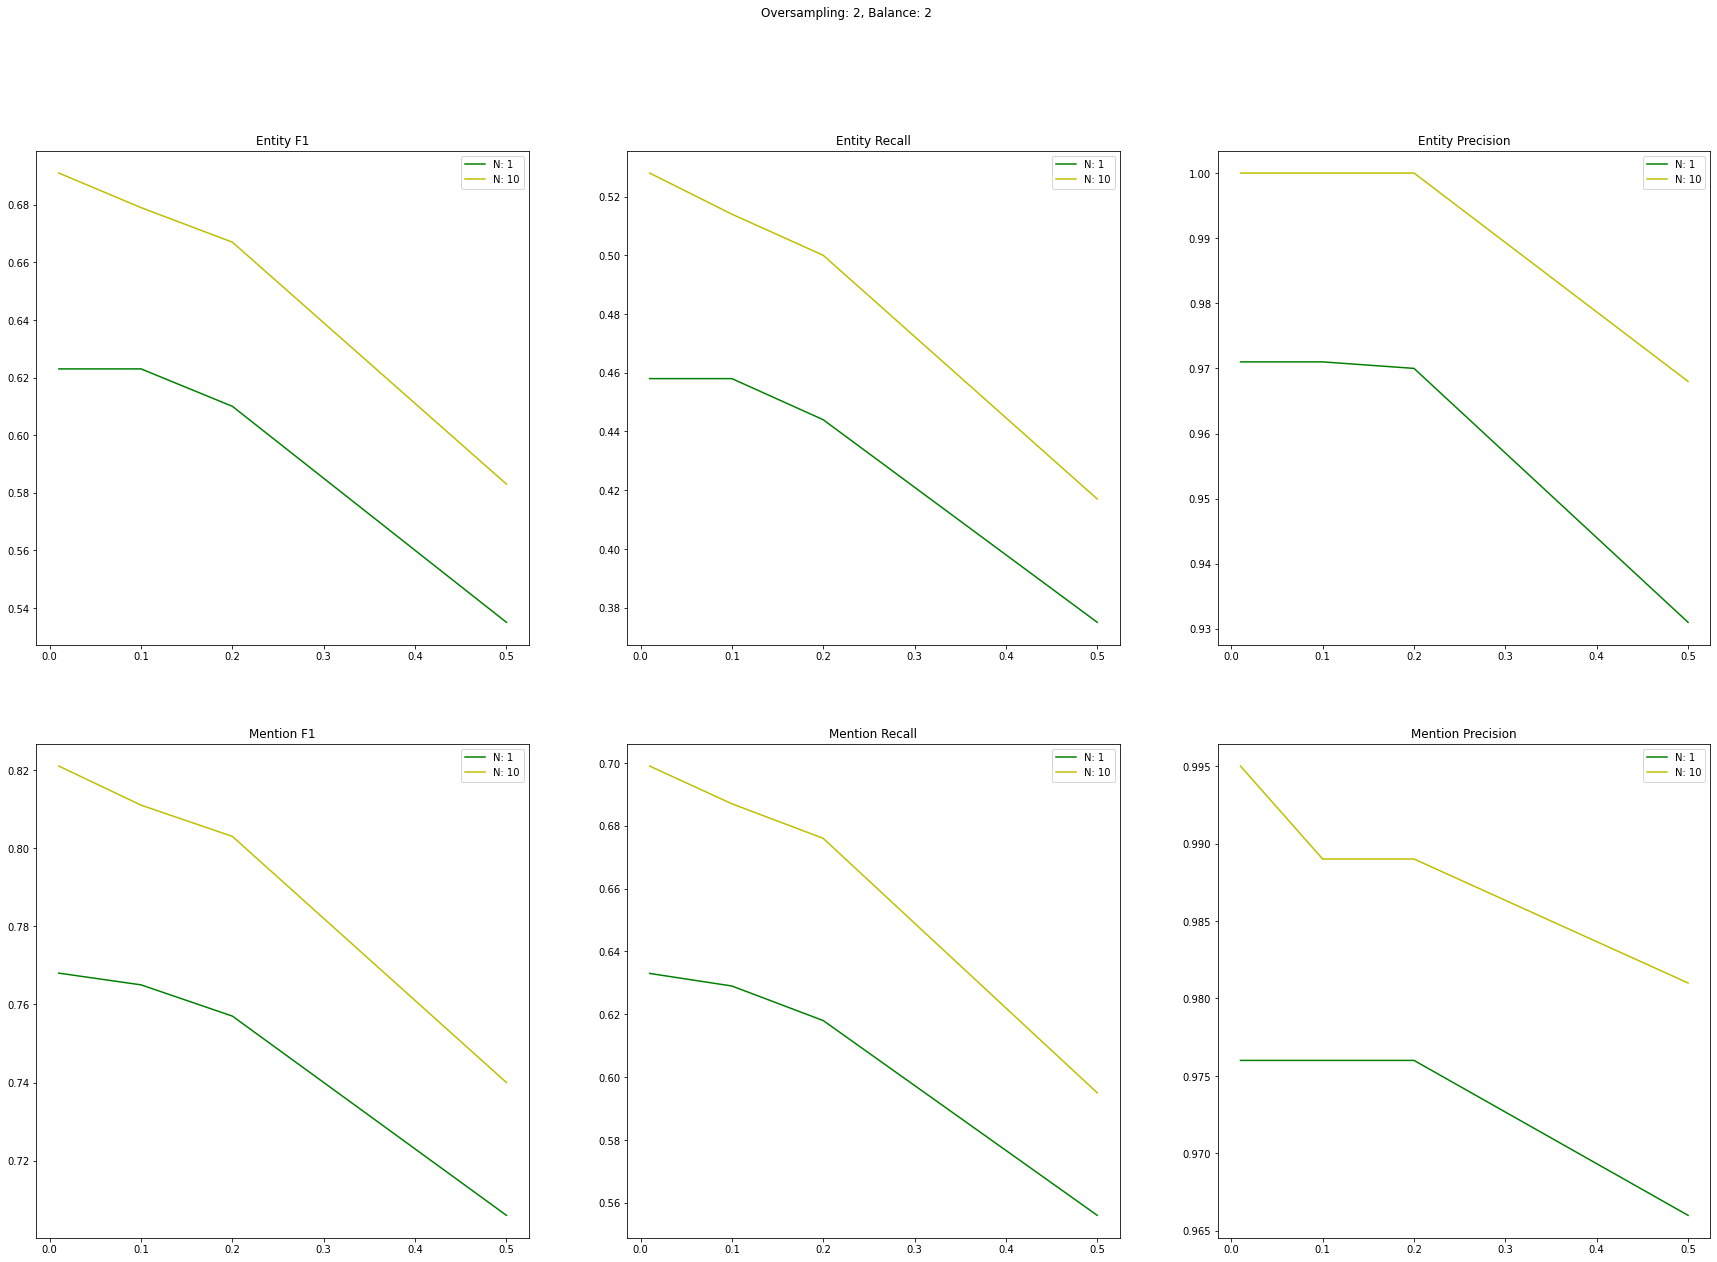

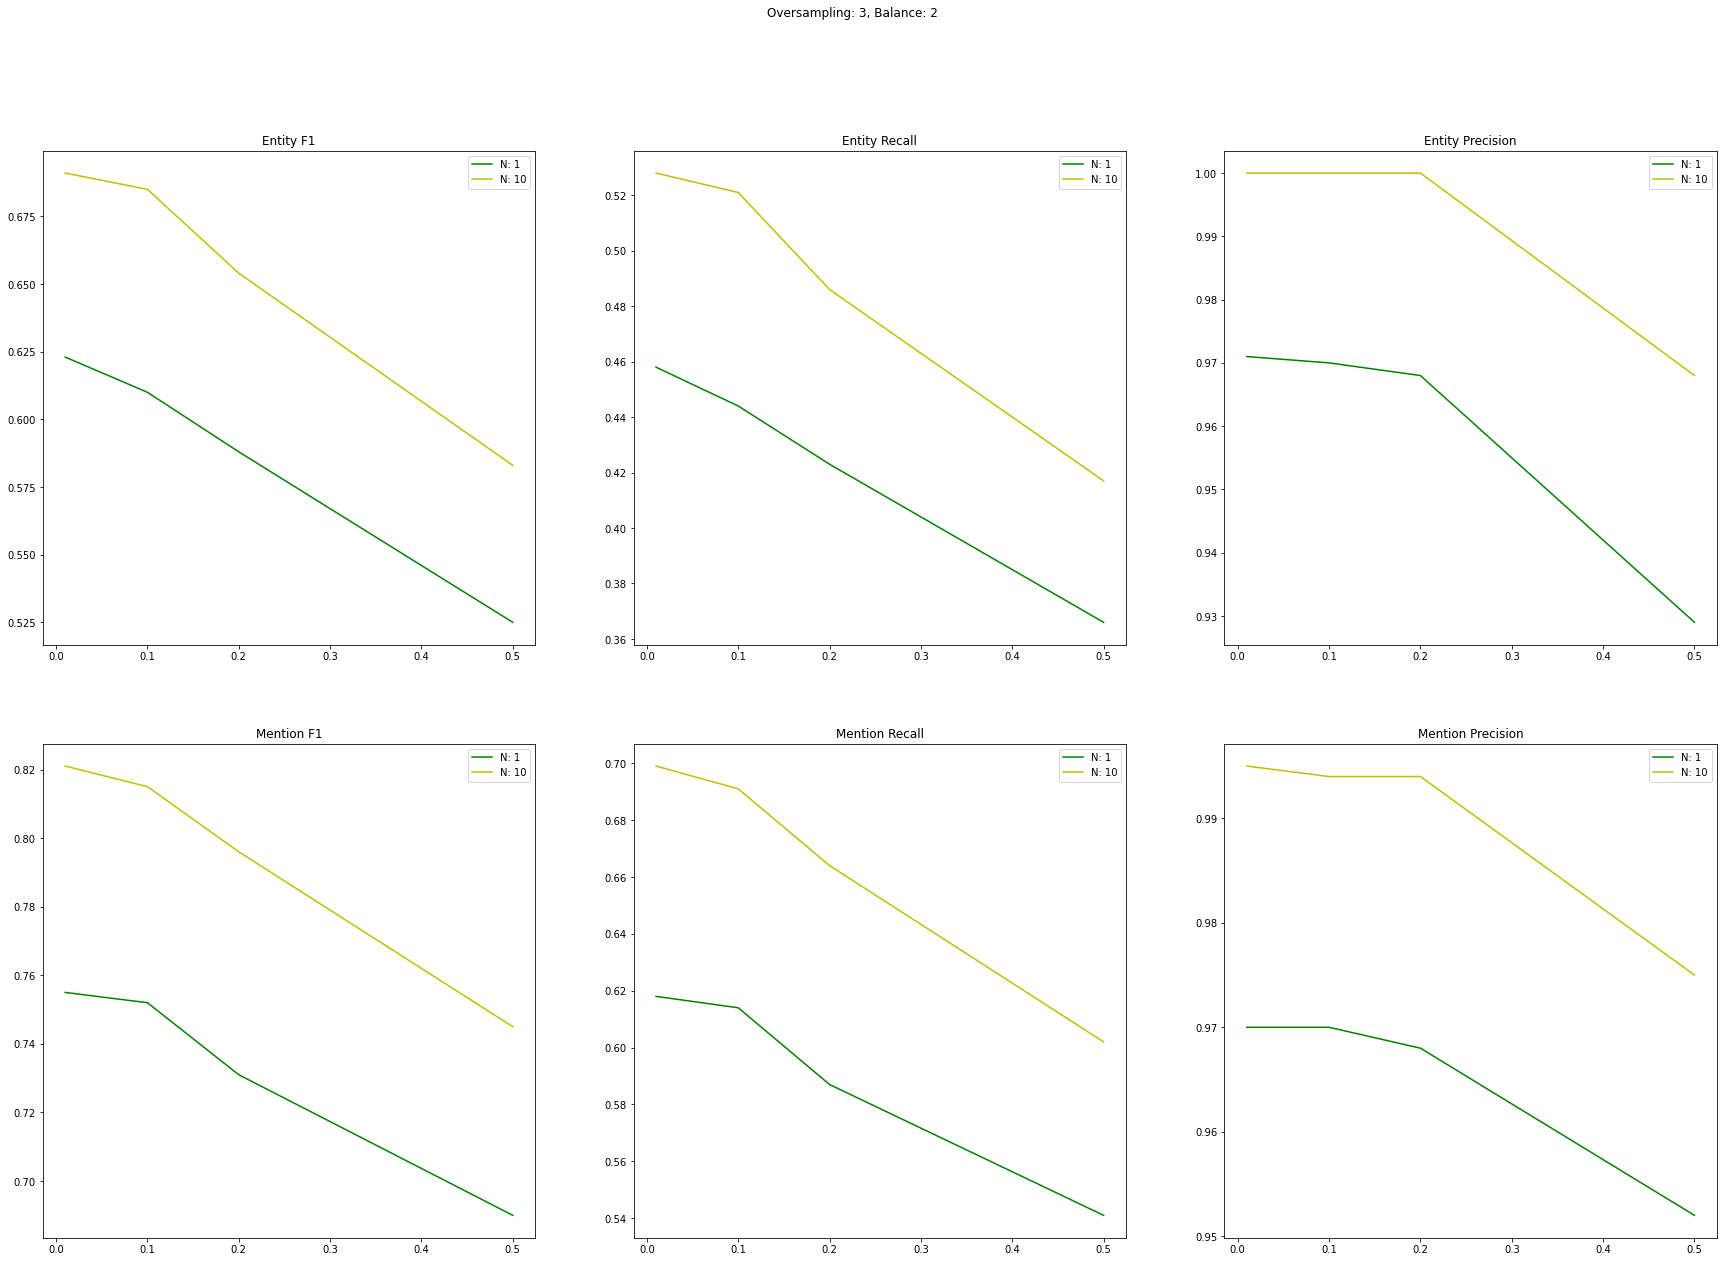

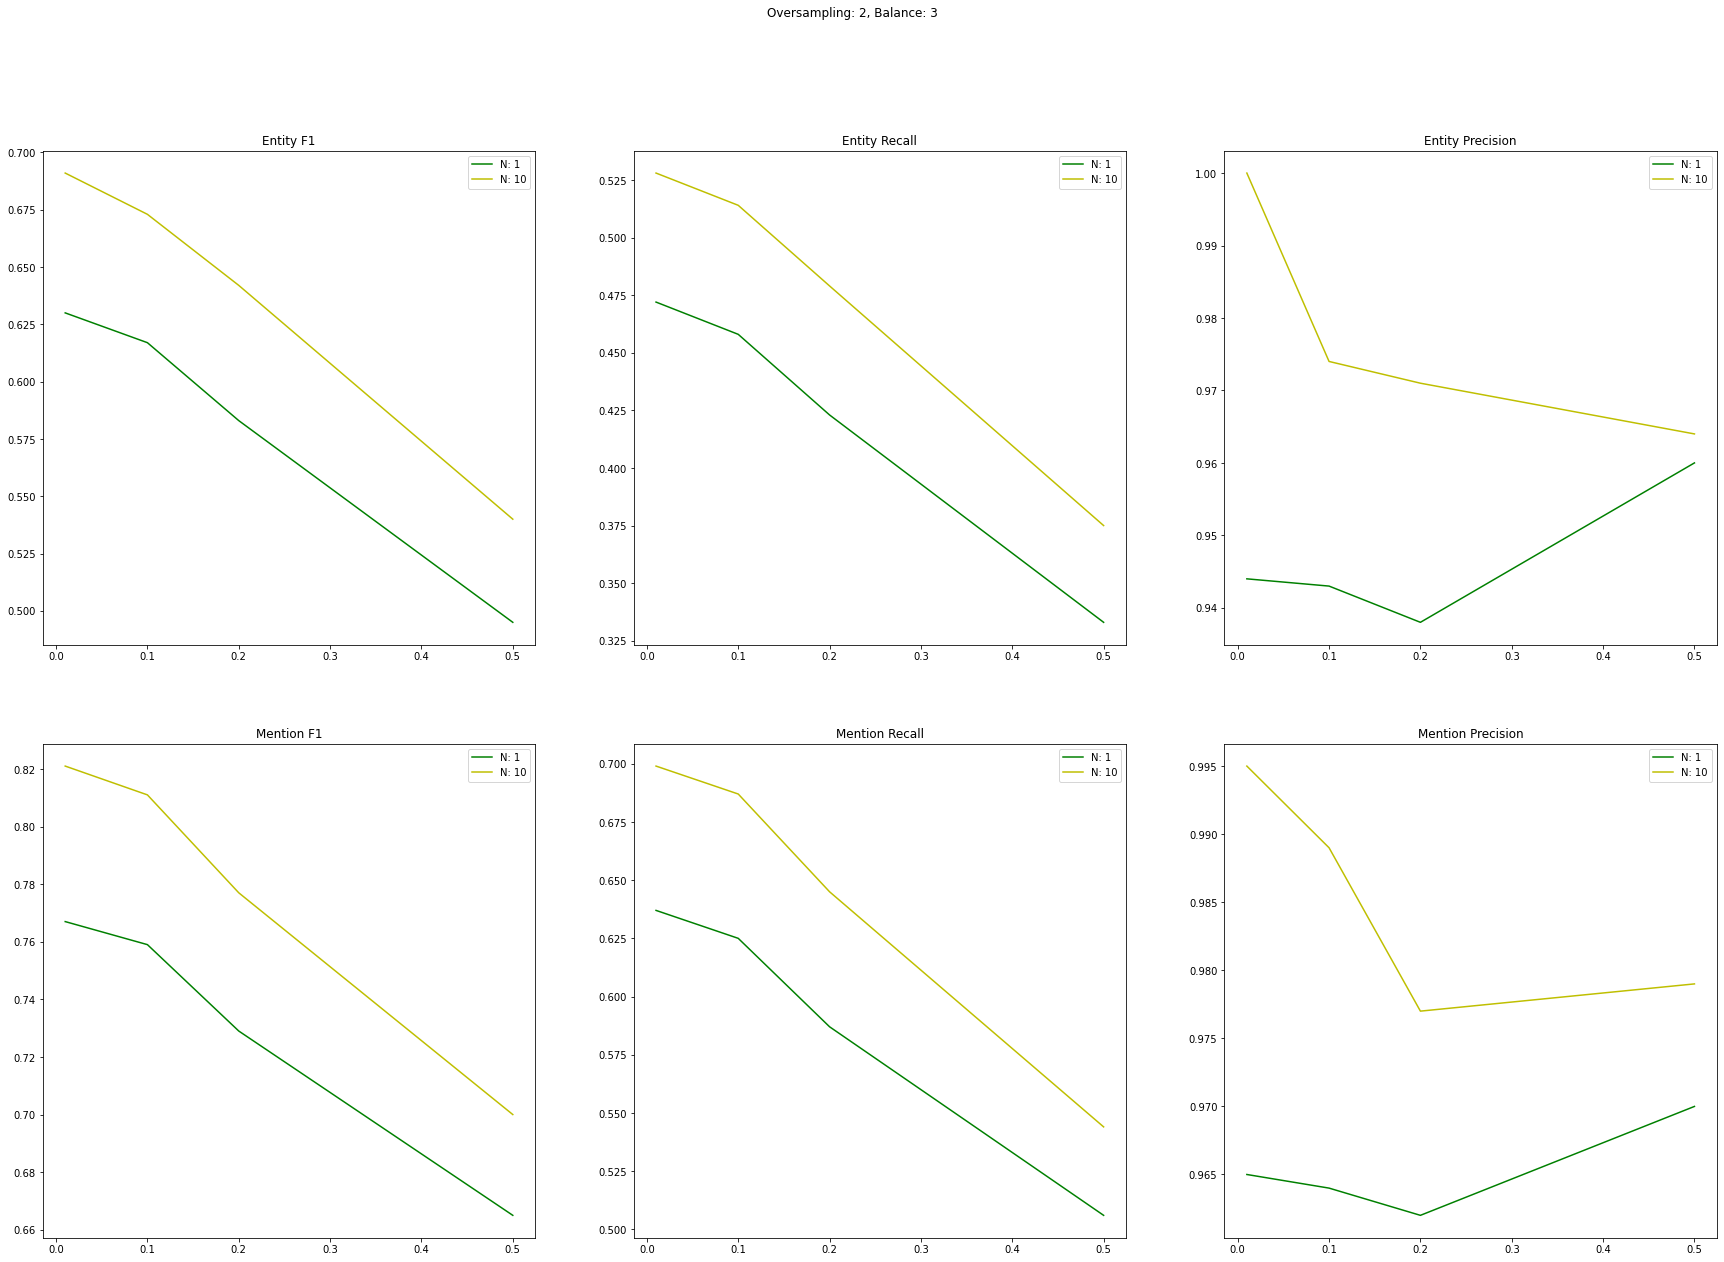

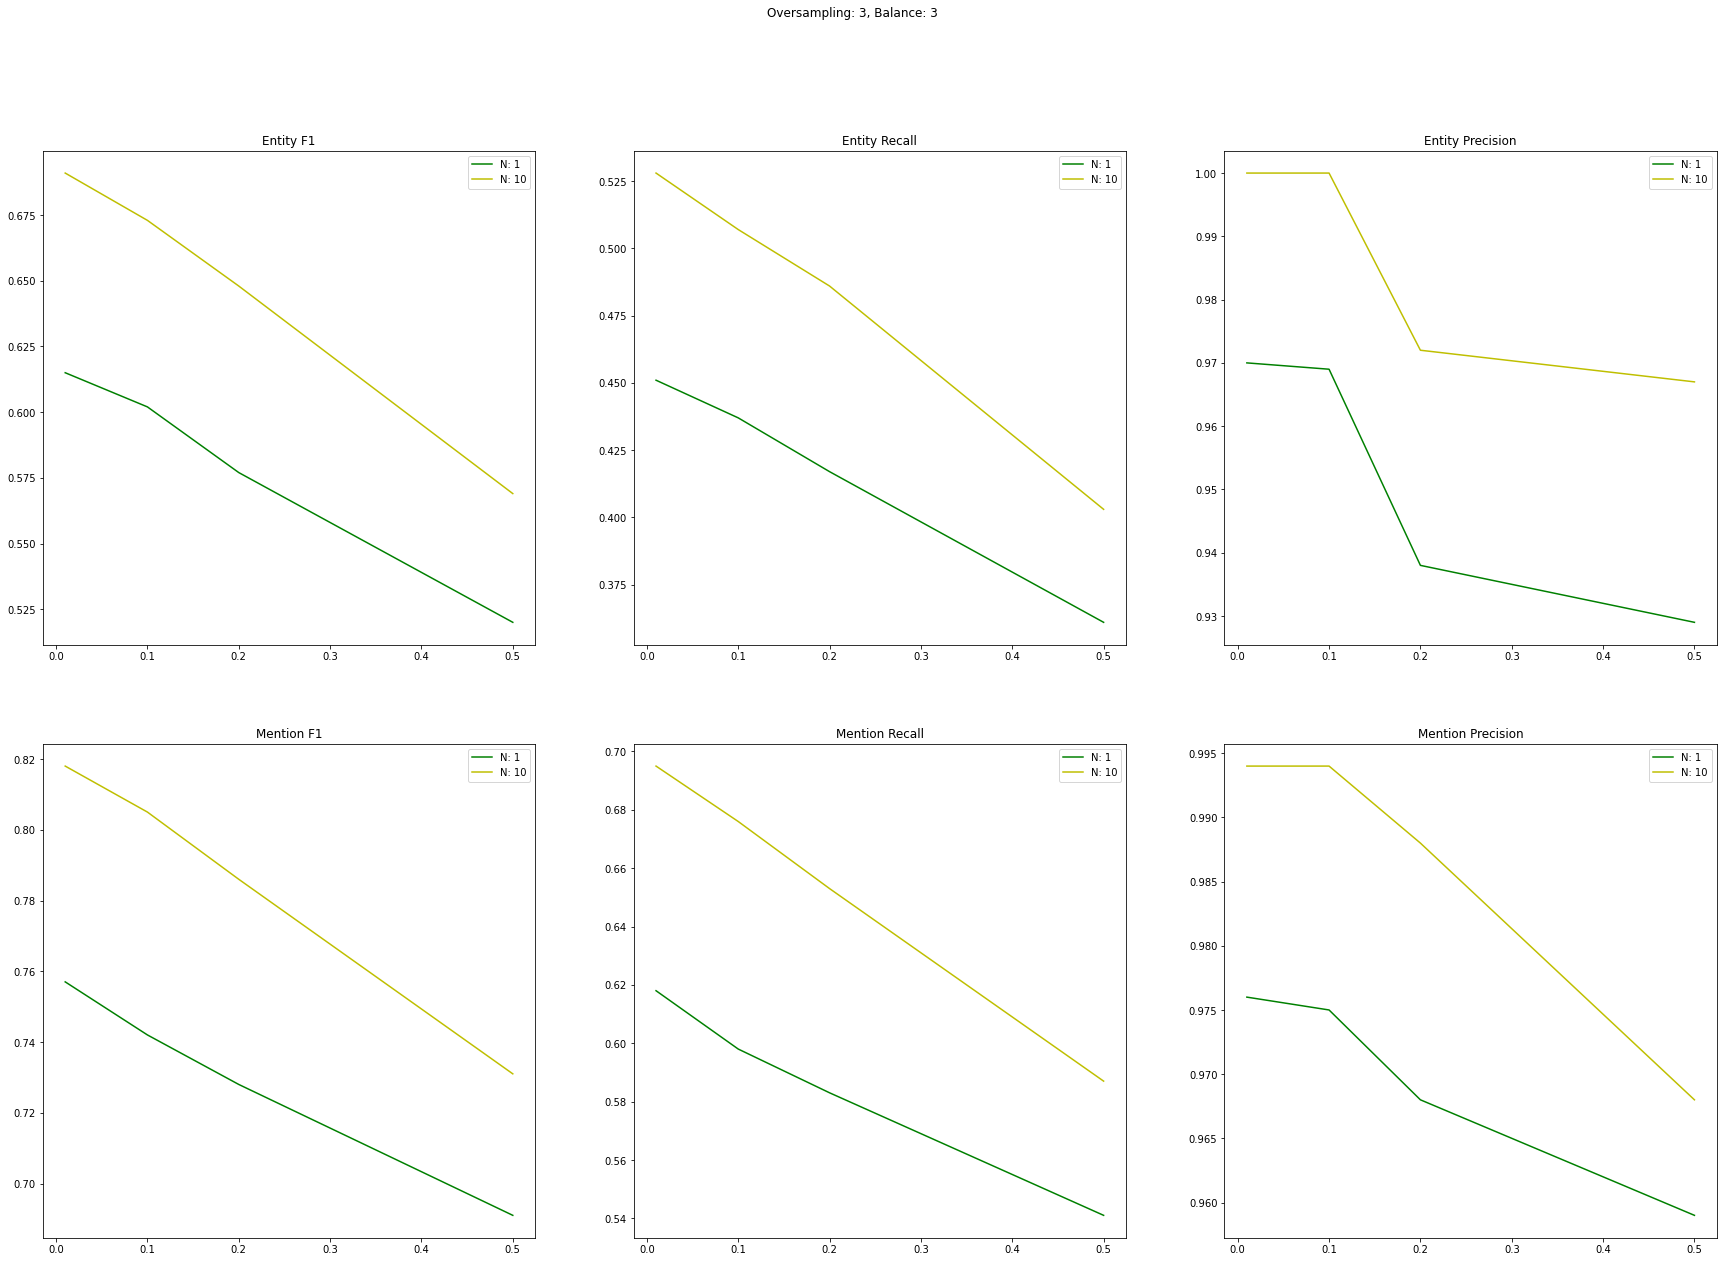

In [15]:
import os

do_sample = True
keep_empty = True
model = "Tree Reg Squared"
data = "combined"

if not os.path.exists('plots'):
    os.makedirs('plots')
    
for balance in balance_list:
    for oversampling in oversampling_list:
        plot_metrics_over_threshold(
            thresholds=thresholds, 
            n_s=n_s, 
            oversampling=oversampling, 
            balance=balance, 
            do_sample=True, 
            keep_empty=True, 
            model=model,
            data=data,
            results=results)

In [22]:
# top_10 scores are necessarily better than top_1 scores, here we can decide which one we choose to get metrics about
top_n = 1

In [23]:
def extract(scores, score_name, dict, current_setup, top_n):
    for score in scores:
        score_dict = score["score"].get_score()
        if score["top_n"] == top_n:
            curr_setup["top_n"] = score["top_n"]
            curr_setup["threshold"] = score["threshold"]
            if score_dict[score_name] > dict[f"top_{score_name}"]:
                dict[f"top_{score_name}"] = score_dict[score_name]
                dict[f"top_{score_name}_setup"] = [current_setup]
            elif score_dict[score_name] == dict[f"top_{score_name}"]:
                dict[f"top_{score_name}_setup"].append(current_setup)
    return dict

model_results = []
for model_name in model_names:
    dictionary={
        "ent": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        },
        "ment": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        }
    }
    for di in results:
        if di["model"] == model_name:
            for scoring_level in ["ent", "ment"]:
                scores = di[f"{scoring_level}_scores"]
                curr_setup = {
                    "data": di["data"],
                    "do_sample": di["do_sample"],
                    "balance": di["balance"],
                    "oversampling": di["oversampling"],
                    "keep_empty": di["keep_empty"]
                }
                for score_name in ["F1", "Recall", "Precision"]:
                    dictionary[scoring_level] = extract(scores, score_name, dictionary[scoring_level], curr_setup, top_n=top_n )
    model_results.append(dictionary)        


In [24]:
score = "F1"

In [25]:
for scores, model_name in zip(model_results, model_names):
    balance = []
    combined = []
    oversampling = []
    keep_empty = []
    do_sample = []
    top_n = []
    thresholds = []
    print(model_name)
    for scoring_level in ["ent", "ment"]:
        print(f"{scoring_level}\t", f"{score}:\t", scores[scoring_level][f"top_{score}"])
        print(f"{scoring_level}\t", f"{score} Setup:")
        for setup in scores[scoring_level][f"top_{score}_setup"]:
            if setup["data"] == "cleaned":
                combined.append(0)
            else:
                combined.append(1)
            balance.append(setup["balance"])
            oversampling.append(setup["oversampling"])
            top_n.append(setup["top_n"])
            thresholds.append(setup["threshold"])
            if setup["do_sample"]:
                do_sample.append(1)
            else:
                do_sample.append(0)
            if setup["keep_empty"]:
                keep_empty.append(1)
            else:
                keep_empty.append(0)
    
        print(f"Number of setups: {len(do_sample)}")

        print("Mean")
        print("sample", np.mean(do_sample))
        print("empty ", np.mean(keep_empty))
        print("combin", np.mean(combined))
        print("tresh ", np.mean(thresholds))
        print("top_n ", np.mean(top_n))
        print("overs ", np.mean(oversampling))
        print("balanc", np.mean(balance))

        print("Median")
        print("sample", np.median(do_sample))
        print("empty ", np.median(keep_empty))
        print("combin", np.median(combined))
        print("tresh ", np.median(thresholds))
        print("top_n ", np.median(top_n))
        print("overs ", np.median(oversampling))
        print("balanc", np.median(balance))
        print("\n\n")
            

Tree Reg Squared
ent	 F1:	 0.641
ent	 F1 Setup:
Number of setups: 1
Mean
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0
Median
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0



ment	 F1:	 0.779
ment	 F1 Setup:
Number of setups: 2
Mean
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0
Median
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0





After some tests we find:
- ExtraTreesRegressor works best
- with: 
    - Balance = 1
    - Oversampling = 1
    - do_sample = True
    - keep_empty = True
    - treshold = 0.1 or smaller is more stable in advers conditions for balance 1 and oversampling 1 it does not matter -> this makes the regression more stable
    - => n -> does not matter so much can amolst go to 1 !!!!

- problematic entities seem to help 